# 🌦️📞 Weather vs. Animal Complaint Correlation (2020–2025)
This notebook performs a correlation analysis between daily weather variables and 311 animal-related complaint counts in Boston from 2020 to 2025.

It includes:
- Loading and merging daily weather data (2020–2025)
- Loading and aggregating animal complaint data by date
- Merging the datasets
- Correlation analysis and visualizations

In [17]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from folium.plugins import HeatMapWithTime
import folium
from sklearn.cluster import KMeans
import holidays
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 🧊 Load Weather Data (2020–2025)

In [5]:
weather_files = [
    "../data/Boston, MA, United States... 2020-01-01 to 2020-12-31.csv",
    "../data/Boston, MA, United States... 2021-01-01 to 2021-12-31.csv",
    "../data/Boston, MA, United States... 2022-01-01 to 2022-12-31.csv",
    "../data/Boston, MA, United States... 2023-01-01 to 2023-12-31.csv",
    "../data/Boston, MA, United States... 2024-01-01 to 2024-12-31.csv",
    "../data/Boston, MA, United States... 2025-01-01 to 2025-04-30.csv"
]
weather_dfs = []

for file in weather_files:
    df = pd.read_csv(file, parse_dates=['datetime'])
    df = df.rename(columns={
        "datetime": "date",
        "temp": "avg_temp",
        "precip": "precipitation",
        "humidity": "humidity_percent"
    })
    weather_dfs.append(df[['date', 'avg_temp', 'precipitation', 'humidity_percent']])

weather_data = pd.concat(weather_dfs, ignore_index=True)
print("Weather data shape:", weather_data.shape)
weather_data.head()


Weather data shape: (1947, 4)


,date,avg_temp,precipitation,humidity_percent
0,2020-01-01,39.0,0.000,55.7
1,2020-01-02,40.9,0.000,50.5
2,2020-01-03,47.8,0.000,56.3
3,2020-01-04,45.2,0.124,78.4
4,2020-01-05,37.2,0.122,59.6


## 🐾 Load and Aggregate Animal Complaints (2020–2025)

In [7]:
complaint_files = [
    "../data/2020.csv", "../data/2021.csv", "../data/2022.csv",
    "../data/2023.csv", "../data/2024.csv", "../data/2025.csv"
]
complaint_dfs = []

for file in complaint_files:
    df = pd.read_csv(file, parse_dates=['open_dt'])
    df = df[df['type'].str.contains("animal", case=False, na=False)]
    df['date'] = df['open_dt'].dt.date
    complaint_dfs.append(df[['date']])

complaints = pd.concat(complaint_dfs, ignore_index=True)
complaint_counts = complaints.groupby('date').size().reset_index(name='complaint_count')
complaint_counts['date'] = pd.to_datetime(complaint_counts['date'])

print("Complaint data shape:", complaint_counts.shape)
complaint_counts.head()


C:\Users\bukho\AppData\Local\Temp\ipykernel_35684\1205049290.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, parse_dates=['open_dt'])
C:\Users\bukho\AppData\Local\Temp\ipykernel_35684\1205049290.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, parse_dates=['open_dt'])
C:\Users\bukho\AppData\Local\Temp\ipykernel_35684\1205049290.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, parse_dates=['open_dt'])
C:\Users\bukho\AppData\Local\Temp\ipykernel_35684\1205049290.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, parse_dates=['open_dt'])


Complaint data shape: (1946, 2)


,date,complaint_count
0,2020-01-01,19
1,2020-01-02,20
2,2020-01-03,16
3,2020-01-04,15
4,2020-01-05,17


## 🔗 Merge Weather and Complaint Data

In [8]:
merged = pd.merge(complaint_counts, weather_data, on='date')
print("Merged data shape:", merged.shape)
merged.head()


Merged data shape: (1946, 5)


,date,complaint_count,avg_temp,precipitation,humidity_percent
0,2020-01-01,19,39.0,0.000,55.7
1,2020-01-02,20,40.9,0.000,50.5
2,2020-01-03,16,47.8,0.000,56.3
3,2020-01-04,15,45.2,0.124,78.4
4,2020-01-05,17,37.2,0.122,59.6


## 📊 Correlation Heatmap

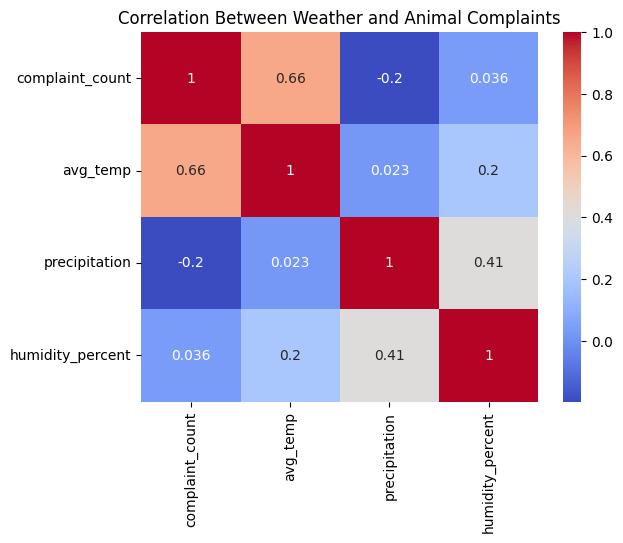

In [9]:
corr = merged.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Weather and Animal Complaints")
plt.show()


## 🌡️ Scatter Plots: Weather vs. Complaints

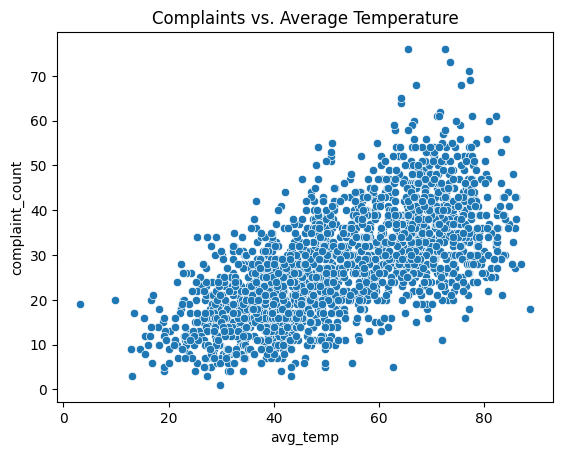

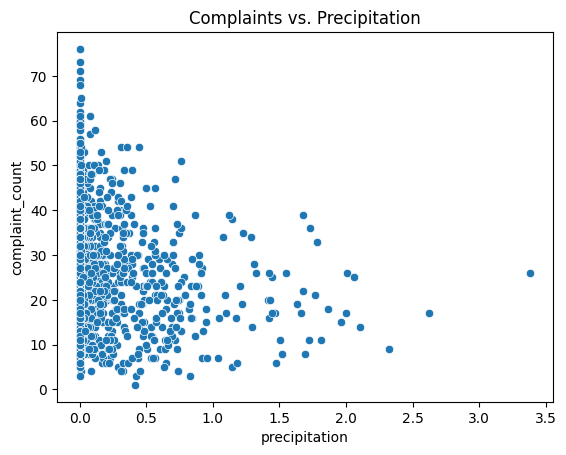

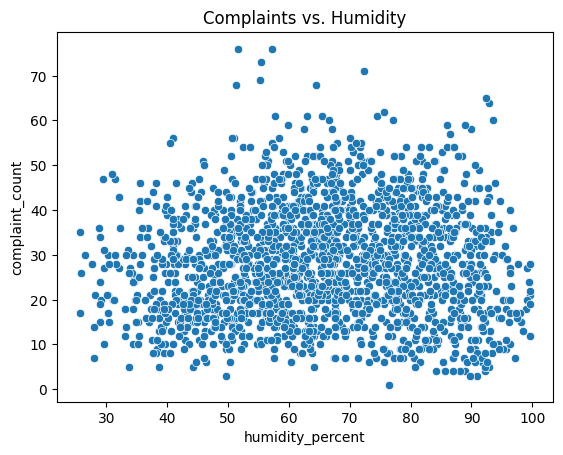

In [10]:
sns.scatterplot(data=merged, x='avg_temp', y='complaint_count')
plt.title("Complaints vs. Average Temperature")
plt.show()

sns.scatterplot(data=merged, x='precipitation', y='complaint_count')
plt.title("Complaints vs. Precipitation")
plt.show()

sns.scatterplot(data=merged, x='humidity_percent', y='complaint_count')
plt.title("Complaints vs. Humidity")
plt.show()


# 📅📞 Seasonal and Weather-Based Analysis of Animal Complaints
This expands the correlation study between weather and 311 animal complaints by including:
- Seasonal Decomposition
- Holiday Analysis
- Folium Heatmaps (with animation)
- K-Means Clustering
- Lag Analysis: Do Rainy Days Increase Complaints the Next Day?


## 🔄 Seasonal Decomposition

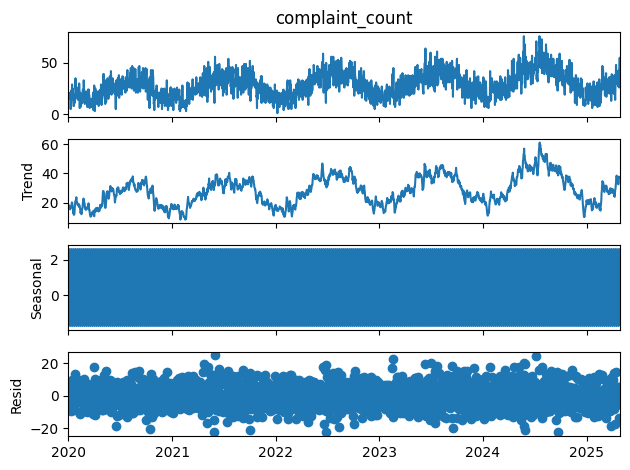

In [12]:
# Requires daily complaint data with no missing dates
merged.set_index('date', inplace=True)
daily = merged['complaint_count'].resample('D').sum().interpolate()
decomp = seasonal_decompose(daily, model='additive')
decomp.plot();

## 🎉 Holiday Analysis (US Federal Holidays)

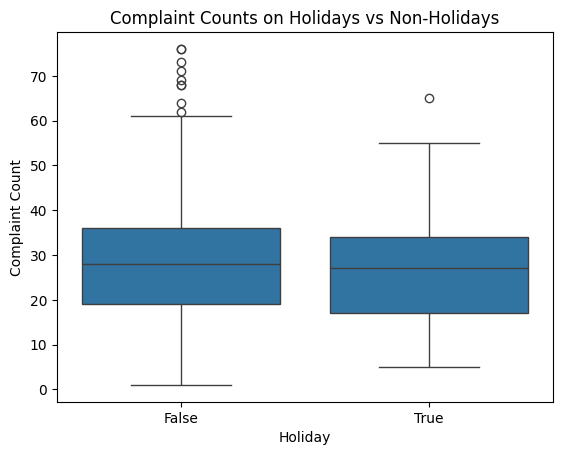

In [13]:
us_holidays = holidays.US()
merged['is_holiday'] = merged.index.to_series().apply(lambda x: x in us_holidays)
sns.boxplot(data=merged, x='is_holiday', y='complaint_count')
plt.title('Complaint Counts on Holidays vs Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Complaint Count')
plt.show()

## 🗺️ Folium HeatMap Animation (Daily Hotspots)

In [14]:
from folium.plugins import HeatMapWithTime
df_map = df.copy()
df_map['date'] = pd.to_datetime(df_map['open_dt']).dt.date
grouped = df_map.groupby('date')
heat_data = [[list(row[['latitude', 'longitude']]) for i, row in group.iterrows()] for _, group in grouped]
m = folium.Map(location=[42.3601, -71.0589], zoom_start=11)
HeatMapWithTime(heat_data, index=sorted(grouped.groups.keys())).add_to(m)
m

## 🔵 K-Means Clustering of Complaint Locations

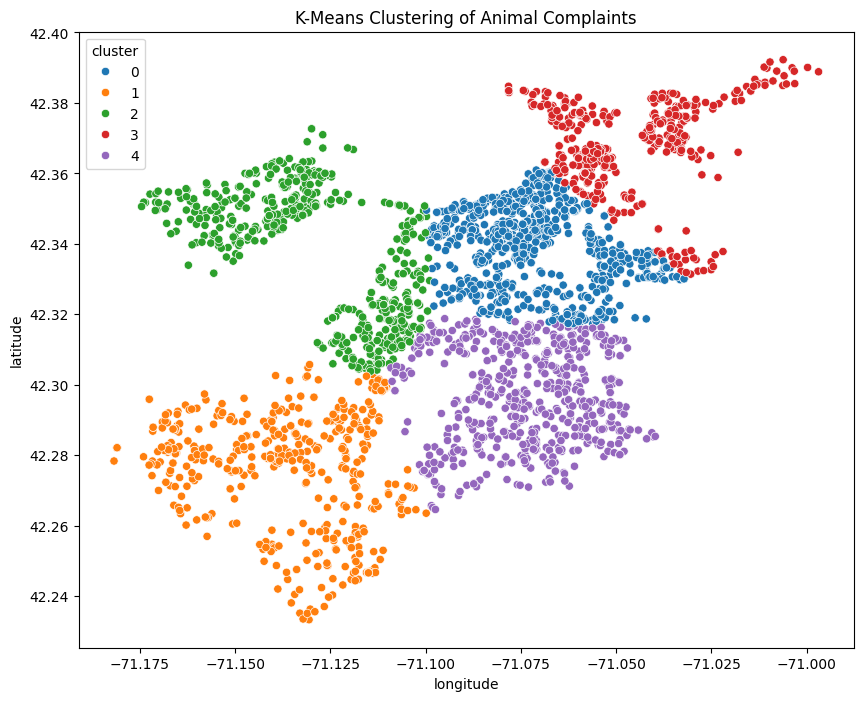

In [15]:
coords = df[['latitude', 'longitude']].dropna()
kmeans = KMeans(n_clusters=5, random_state=42)
coords['cluster'] = kmeans.fit_predict(coords)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=coords, x='longitude', y='latitude', hue='cluster', palette='tab10')
plt.title('K-Means Clustering of Animal Complaints')
plt.show()

## 🌧️ Lag Analysis: Do Rainy Days Increase Complaints the Next Day?

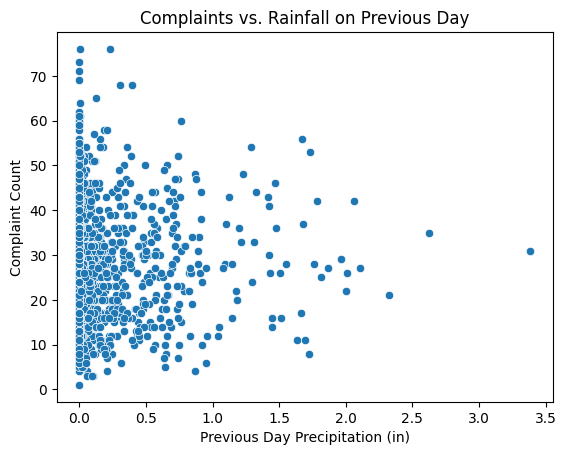

In [16]:
merged = merged.reset_index()
merged['rain_next_day'] = merged['precipitation'].shift(1)
sns.scatterplot(data=merged, x='rain_next_day', y='complaint_count')
plt.title('Complaints vs. Rainfall on Previous Day')
plt.xlabel('Previous Day Precipitation (in)')
plt.ylabel('Complaint Count')
plt.show()

# 🤖 Predicting Animal Complaint Volume from Weather and Temporal Features
This trains a model to predict daily animal complaint counts based on:
- 📅 Day of Week
- ❄️ Season
- 🌡️ Weather (Temperature, Precipitation, Humidity)

It includes:
- Feature engineering
- Model training using Linear Regression and Random Forest
- Evaluation metrics (R², MAE, RMSE)

## 📥 Load Merged Dataset

In [19]:
# Assumes 'merged' DataFrame is already created and includes date, complaint_count, avg_temp, precipitation
merged['date'] = pd.to_datetime(merged['date'])
df_model = merged.copy()
df_model = df_model.dropna(subset=['complaint_count', 'avg_temp', 'precipitation'])

## 🛠 Feature Engineering

In [20]:
# Day of week
df_model['day_of_week'] = df_model['date'].dt.dayofweek  # 0=Monday
# Season
df_model['month'] = df_model['date'].dt.month
df_model['season'] = df_model['month'] % 12 // 3  # 0=Winter, 1=Spring, etc.

## 🎯 Define Features and Target

In [21]:
X = df_model[['day_of_week', 'season', 'avg_temp', 'precipitation']]
y = df_model['complaint_count']

## 🔪 Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🔁 Train Models

In [23]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 📊 Evaluate Models

In [25]:
def evaluate(model, name):
    preds = model.predict(X_test)
    print(f"{name}:")
    print("R²:", r2_score(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", mean_squared_error(y_test, preds) ** 0.5)
    print()

evaluate(lr, "Linear Regression")
evaluate(rf, "Random Forest")

Linear Regression:
R²: 0.46926216474331295
MAE: 7.105159435574546
RMSE: 8.764844017692523

Random Forest:
R²: 0.3103811324556889
MAE: 7.975274053724054
RMSE: 9.990994842340795



## 📈 Actual vs. Predicted Plot

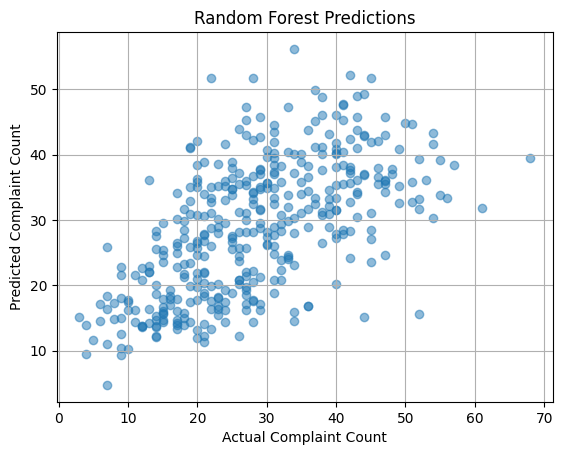

In [26]:
preds = rf.predict(X_test)
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Complaint Count")
plt.ylabel("Predicted Complaint Count")
plt.title("Random Forest Predictions")
plt.grid(True)
plt.show()